# Sampling

In this first exercise, we will investigate how to evaluate the Q-value of each action available in a 5-armed bandit. It is mostly to give you intuition about the limits of sampling and the central limit theorem.

Let's start with importing numpy and matplotlib:

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

## Sampling a n-armed bandit

Let's now create the n-armed bandit. The only thing we need to do is to randomly choose 5 true Q-values $Q^*(a)$.

![](../img/bandit-example.png)

To be generic, let's define `nb_actions=5` and create an array corresponding to the index of each action (0, 1, 2, 3, 4) for plotting purpose.

In [2]:
nb_actions = 5
actions = np.arange(nb_actions)

**Q:** Create a numpy array `Q_star` with `nb_actions` values, normally distributed with a mean of 0 and standard deviation of 1 (as in the lecture).  

In [3]:
rng = np.random.default_rng()
Q_star = rng.normal(0, 1, nb_actions)

**Q:** Plot the Q-values. Identify the optimal action $a^*$.

*Tip:* you could plot the array `Q_star` with `plt.plot`, but that would be ugly. Check the documentation of the `plt.bar` method.

Optimal action: 2


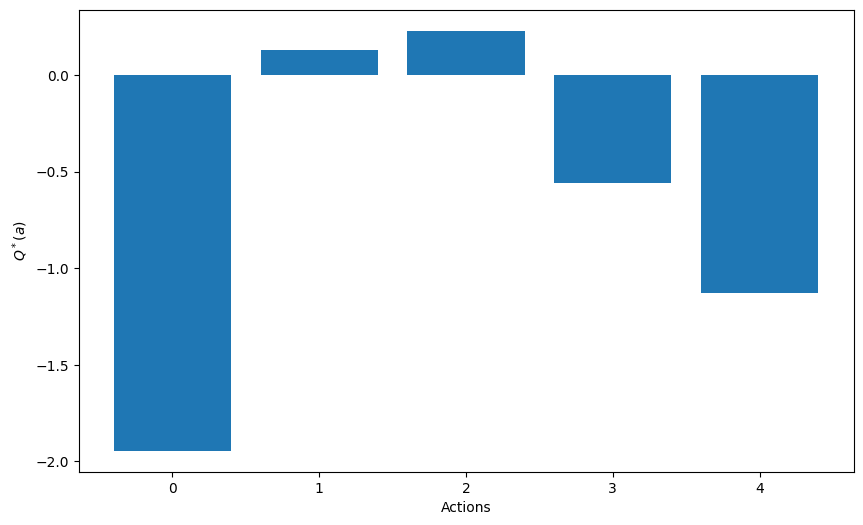

In [4]:
print("Optimal action:", Q_star.argmax())

plt.figure(figsize=(10, 6))
plt.bar(actions, Q_star)
plt.xlabel('Actions')
plt.ylabel('$Q^*(a)$')
plt.show()

Great, now let's start evaluating these Q-values with random sampling.

**Q:** Define an action sampling method `get_reward` taking as arguments:
* The array `Q_star`.
* The index `a` of the action you want to sample (between 0 and 4).
* An optional variance argument `var`, which should have the value 1.0 by default.
   
It should return a single value, sampled from the normal distribution with mean `Q_star[a]` and variance `var`.

In [5]:
def get_reward(Q_star, a, var=1.0):
    return float(rng.normal(Q_star[a], var, 1)[0])

**Q:** For each possible action `a`, take `nb_samples=10` out of the reward distribution and store them in a numpy array. Compute the mean of the samples for each action separately in a new array `Q_t`. Make a bar plot of these estimated Q-values.

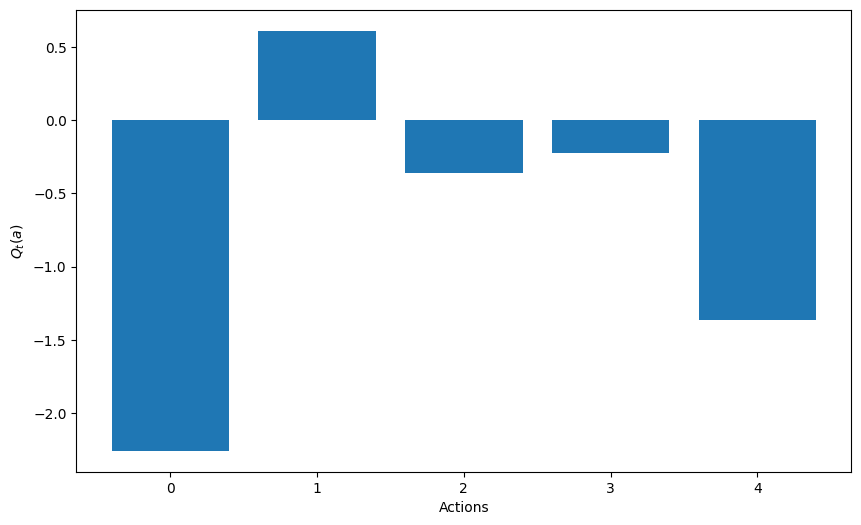

In [6]:
nb_samples = 10
rewards = np.zeros((nb_actions, nb_samples))

for a in actions:
    for play in range(nb_samples):
        rewards[a, play] = get_reward(Q_star, a, var=1.0)

Q_t = np.mean(rewards, axis=1)
    
plt.figure(figsize=(10, 6))
plt.bar(actions, Q_t)
plt.xlabel('Actions')
plt.ylabel('$Q_t(a)$')
plt.show()

**Q:** Make a bar plot of the difference between the true values `Q_star` and the estimates `Q_t`. Conclude. Re-run the sampling cell with different numbers of samples.

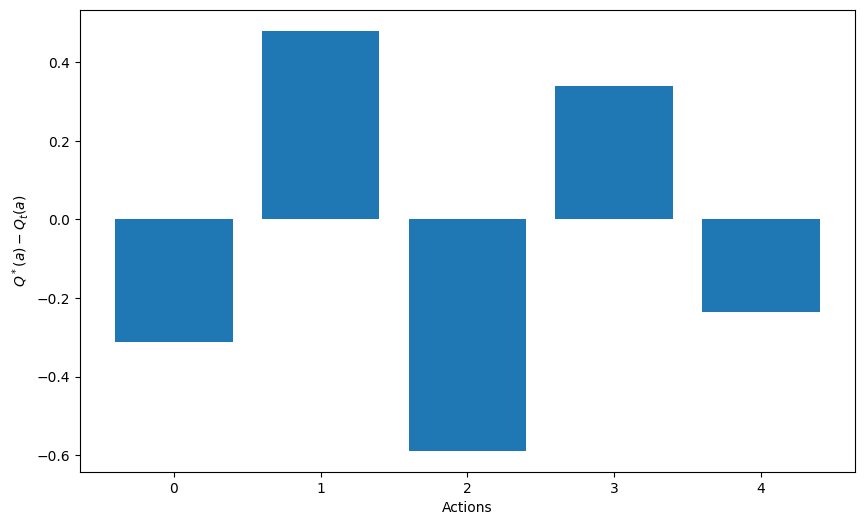

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(actions, Q_t - Q_star)
plt.xlabel('Actions')
plt.ylabel('$Q^*(a) - Q_t(a)$')
plt.show()

**Q:** To better understand the influence of the number of samples on the accuracy of the sample average, create a `for` loop over the preceding code, with a number of samples increasing from 1 to 100. For each value, compute the **mean square error** (mse) between the estimates `Q_t` and the true values `Q^*`.

The mean square error is simply defined over the `N = nb_actions` actions as:

$$\epsilon = \frac{1}{N} \, \sum_{a=0}^{N-1} (Q_t(a) - Q^*(a))^2$$

At the end of the loop, plot the evolution of the mean square error with the number of samples. You can append each value of the mse in an empty list and then plot it with `plt.plot`, for example. 

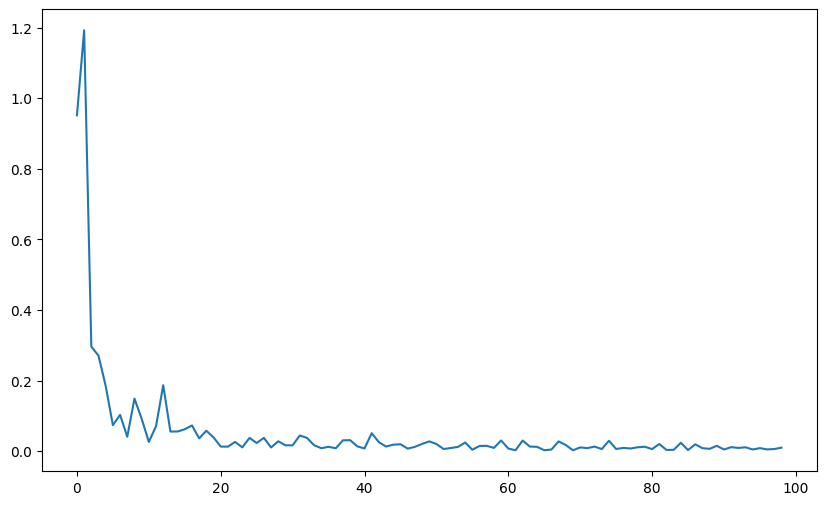

In [8]:
errors = []
for nb_sample in range(1, 100):
    
    rewards = np.zeros((nb_actions, nb_sample))

    for a in actions:
        for play in range(nb_sample):
            rewards[a, play] = get_reward(Q_star, a, var=1.0)

    Q_t = np.mean(rewards, axis=1)
    error = np.mean((Q_star - Q_t)**2)
    errors.append(error)
    
plt.figure(figsize=(10, 6))
plt.plot(errors)
plt.show()

The plot should give you an indication of how many samples you at least need to correctly estimate each action (30 or so). But according to the central limit theorem (CLT), the variance of the sample average also varies with the variance of the distribution itself.

> The distribution of sample averages is normally distributed with mean $\mu$ and variance $\frac{\sigma^2}{N}$.

$$S_N \sim \mathcal{N}(\mu, \frac{\sigma}{\sqrt{N}})$$

**Q:** Vary the variance of the reward distribution (as an argument to `get_reward`) and re-run the previous experiment. Do not hesitate to take more samples.  Conclude.

0.1252024683141708


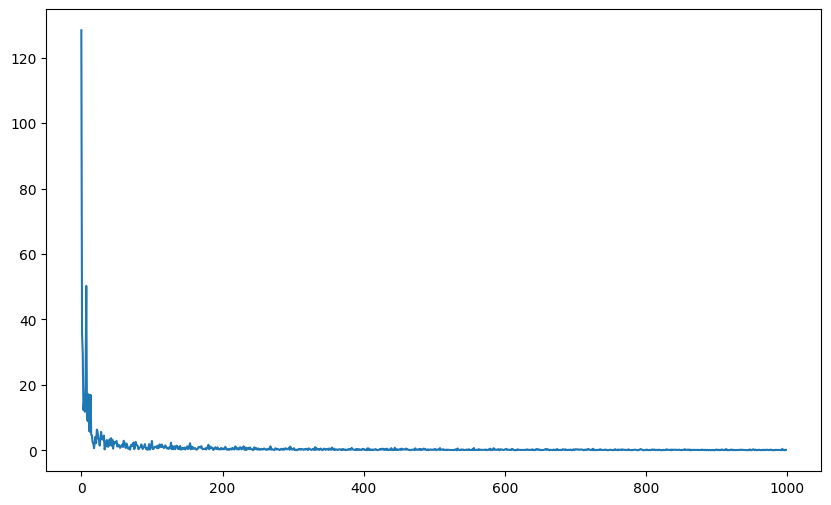

In [9]:
errors = []
for nb_sample in range(1, 1000):
    
    rewards = np.zeros((nb_actions, nb_sample))

    for a in actions:
        for play in range(nb_sample):
            rewards[a, play] = get_reward(Q_star, a, var=10.0)

    Q_t = np.mean(rewards, axis=1)
    error = np.mean((Q_star - Q_t)**2)
    errors.append(error)
    
print(error)

plt.figure(figsize=(10, 6))
plt.plot(errors)
plt.show()

**A:** the higher the variance of the distribution, the more samples we need to get correct estimates.  

## Bandit environment

In order to prepare the next exercise, let's now implement the n-armed bandit in a Python class. As reminded in the tutorial on Python, a class is defined using this structure:

```python
class MyClass:
    """
    Documentation of the class.
    """
    def __init__(self, param1, param2):
        """
        Constructor of the class.
        
        :param param1: first parameter.
        :param param2: second parameter.
        """
        self.param1 = param1
        self.param2 = param2
        
    def method(self, another_param):
        """
        Method to do something.
        
        :param another_param: another parameter.
        """
        return (another_param + self.param1)/self.param2
```

You can then create an object of the type `MyClass`:

```python
my_object = MyClass(param1= 1.0, param2=2.0)
```

and call any method of the class on the object:

```python
result = my_object.method(3.0)
```

**Q:** Create a `Bandit` class taking as arguments:

* nb_actions: number of arms.
* mean: mean of the normal distribution for $Q^*$.
* std_Q: standard deviation of the normal distribution for $Q^*$.
* std_r: standard deviation of the normal distribution for the sampled rewards.

The constructor should initialize a `Q_star` array accordingly and store it as an attribute. It should also store the optimal action.

Add a method `step(action)` that samples a reward for a particular action and returns it.

In [10]:
class Bandit:
    """
    n-armed bandit.
    """
    def __init__(self, nb_actions, mean=0.0, std_Q=1.0, std_r=1.0):
        """
        :param nb_actions: number of arms.
        :param mean: mean of the normal distribution for $Q^*$.
        :param std_Q: standard deviation of the normal distribution for $Q^*$.
        :param std_r: standard deviation of the normal distribution for the sampled rewards.
        """
        # Store parameters
        self.nb_actions = nb_actions
        self.mean = mean
        self.std_Q = std_Q
        self.std_r = std_r
        
        # Initialize the true Q-values
        self.Q_star = rng.normal(self.mean, self.std_Q, self.nb_actions)
        
        # Optimal action
        self.a_star = self.Q_star.argmax()
        
    def step(self, action):
        """
        Sampled a single reward from the bandit.
        
        :param action: the selected action.
        :return: a reward.
        """
        return float(rng.normal(self.Q_star[action], self.std_r, 1)[0])

**Q:** Create a 5-armed bandits and sample each action multiple times. Compare the mean reward to the ground truth as before.

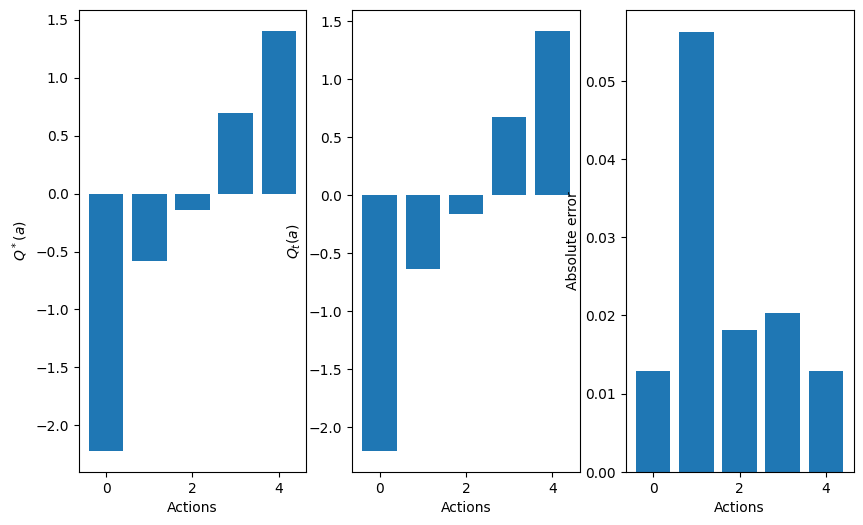

In [11]:
nb_actions = 5
bandit = Bandit(nb_actions)

all_rewards = []
for t in range(1000):
    rewards = []
    for a in range(nb_actions):
        rewards.append(bandit.step(a))
    all_rewards.append(rewards)
    
mean_reward = np.mean(all_rewards, axis=0)

plt.figure(figsize=(10, 6))
plt.subplot(131)
plt.bar(range(nb_actions), bandit.Q_star)
plt.xlabel("Actions")
plt.ylabel("$Q^*(a)$")
plt.subplot(132)
plt.bar(range(nb_actions), mean_reward)
plt.xlabel("Actions")
plt.ylabel("$Q_t(a)$")
plt.subplot(133)
plt.bar(range(nb_actions), np.abs(bandit.Q_star - mean_reward))
plt.xlabel("Actions")
plt.ylabel("Absolute error")
plt.show()